# Temperature Modelling

In [50]:
%pip install numpy
%pip install pandas
%pip install scipy
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [51]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

### Newton's Law of Cooling
The rate of change of temperature of an object is proportional to the difference between its own temperature and the ambient temperature (the temperature of its surroundings).

$$
\frac{dT}{dt} = -k(T - T_a)
$$
Where:
- \(T\) is the temperature of the object at time \(t\)
- \(T_a\) is the ambient temperature
- \(k\) is a positive constant that depends on the characteristics of the object and its surroundings

### Solution to the Differential Equation
$$
T(t) = T_a + (T_0 - T_a)e^{-kt}
$$
Where:
- \(T_0\) is the initial temperature of the object at \(t = 0\)
- \(e\) is the base of the natural logarithm
- \(t\) is the time elapsed (in seconds)
- \(k\) is the cooling constant

In [52]:
# Newton's Law of Cooling
def newtons_law_of_cooling(t, T_0, T_amb, k):
    return T_amb + (T_0 - T_amb) * np.exp(-k * t)

## Data

In [53]:
df = pd.read_csv('dataset.csv')
df.head()

,no,timestamp,T_amb,Temp
0,0,05:45,29.2,97.3
1,1,06:00,29.2,94.8
2,2,06:15,29.1,92.8
3,3,06:30,29.0,90.7
4,4,06:45,29.0,88.9


In [54]:
df.columns = df.columns.str.strip()
n = len(df)
df['Elapsed_Hours'] = np.arange(n) * 0.25 

In [55]:
# Declare Variables

ambient_temperature = df['T_amb'].mean()
temperature = df['Temp'].values
time = df['Elapsed_Hours'].values


## Model

In [56]:
def cooling_model(t, k):
    return ambient_temperature + (temperature[0] - ambient_temperature) * np.exp(-k * t)

In [57]:
k_opt, k_val = curve_fit(cooling_model, time, temperature, bounds=(0, np.inf))
temps_fitted = cooling_model(time, 0.11) # k_opt[0]

print(k_opt[0])
print(k_val[0])

0.12284141685771587
[2.03928966e-06]


This approach uses the curve fitting method to estimate the cooling constant $k$ or time constant $ k $ by minimizing the difference between the observed temperatures and the temperatures predicted by the model. This is more accurate than using just two data points.

What `curve_fit` does is it tries many values of $ k $ and computes:
$$
\text{Error} = \sum_{i}^{} \left[ \text{Observed}_i - \text{Predicted}_i \right] ^{2}
$$

It then picks the $ k $ that minimizes this squared error, that is the best fitting exponential curve to the data.

### Model Fitting

In [58]:
results_df = pd.DataFrame({
    "Time (hours)": time,
    "Observed Temp (°C)": temperature,
    "Fitted Temp (°C)": temps_fitted,
    "Difference (°C)" : (temperature-temps_fitted)
})
results_df

,Time (hours),Observed Temp (°C),Fitted Temp (°C),Difference (°C)
0,0.00,97.3,97.300000,0.000000
1,0.25,94.8,95.447341,-0.647341
2,0.50,92.8,93.644936,-0.844936
3,0.75,90.7,91.891421,-1.191421
4,1.00,88.9,90.185471,-1.285471
5,1.25,87.3,88.525796,-1.225796
6,1.50,85.6,86.911140,-1.311140
7,1.75,84.0,85.340282,-1.340282
8,2.00,82.0,83.812034,-1.812034
9,2.25,81.0,82.325240,-1.325240


### Extrapolation

In [59]:
extrapolate_time = np.arange(0, 300.25, 0.25)
extrapolate_temperature = cooling_model(extrapolate_time, k_opt[0])

extrapolate_df = pd.DataFrame({
    "Time (hours)" : extrapolate_time,
    "Temperature" : extrapolate_temperature
})
extrapolate_df.head()

,Time (hours),Temperature
0,0.00,97.300000
1,0.25,95.234363
2,0.50,93.231199
3,0.75,91.288617
4,1.00,89.404787


In [60]:
# General Information

print("k = ", k_opt[0])
print("Ambient Temperature = ", ambient_temperature)
print("Initial Temperature = ", temperature[0])
print("Temperature after 12 hours = ", extrapolate_temperature[48])


k =  0.12284141685771587
Ambient Temperature =  28.999999999999996
Initial Temperature =  97.3
Temperature after 12 hours =  44.63970329898605


In [61]:
def temperature_at_time_t(time_value):
    time_value = float(time_value)
    if not (extrapolate_time.min() <= time_value <= extrapolate_time.max()):
        raise ValueError(
            f"time must be within [{extrapolate_time.min()}, {extrapolate_time.max()}] hours."
        )
    return float(cooling_model(time_value, k_opt[0]))

def time_at_temperature_T(temperature_value):
    temperature_value = float(temperature_value)

    max_temp = float(temperature[0])
    min_temp = float(extrapolate_temperature.min())

    if not (min_temp <= temperature_value <= max_temp):
        raise ValueError(
            f"temperature must be within [{min_temp}, {max_temp}] °C."
        )

    temps_sorted = extrapolate_temperature[::-1]
    times_sorted = extrapolate_time[::-1]
    time_value = np.interp(temperature_value, temps_sorted, times_sorted)
    return float(time_value)


TIME = 13
TEMPERATURE = 30
temperature_at_time_t(TIME), time_at_temperature_T(TEMPERATURE)

(42.83181463923865, 34.386015326840734)

## Out of Sample Test

| Time (hours) | Actual Temp (°C) | Extrapolated Temp (°C) |
| --- | --- | --- |
| 13 | 50.4 | 42.8 |


In [62]:
import pandas as pd

# Load your previous data
data = pd.read_csv('dataset.csv')
data.columns = data.columns.str.strip()

# Add the new observation manually
data.loc[len(data)] = [len(data), '13:00', 27.3, 50.4]


In [63]:
import numpy as np

# First 12 readings (every 15 min)
elapsed_hours = np.arange(len(data) - 1) * 0.25

# Append the 13-hour reading
elapsed_hours = np.append(elapsed_hours, 13.0)

# Now assign to the DataFrame
data['Elapsed_hours'] = elapsed_hours


In [ ]:
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import numpy as np

# Extract variables
T_amb = data['T_amb'].mean()
T_temp = data['Temp'].values
time = data['Elapsed_hours'].values

# Define model
def cooling_model(t, k):
    return T_amb + (T_temp[0] - T_amb) * np.exp(-k * t)

# Fit model using new data
k_new, k_new_val = curve_fit(cooling_model, time, T_temp, bounds=(0, np.inf))

# Compute fitted curve
time_fit = np.linspace(0, 13, 100)
fitted_temps = cooling_model(time_fit, k_new[0])

# Print results
print(f"Updated thermal k: {k_new[0]}")
print(k_new_val[0])


Updated thermal k: 0.11042343169938336


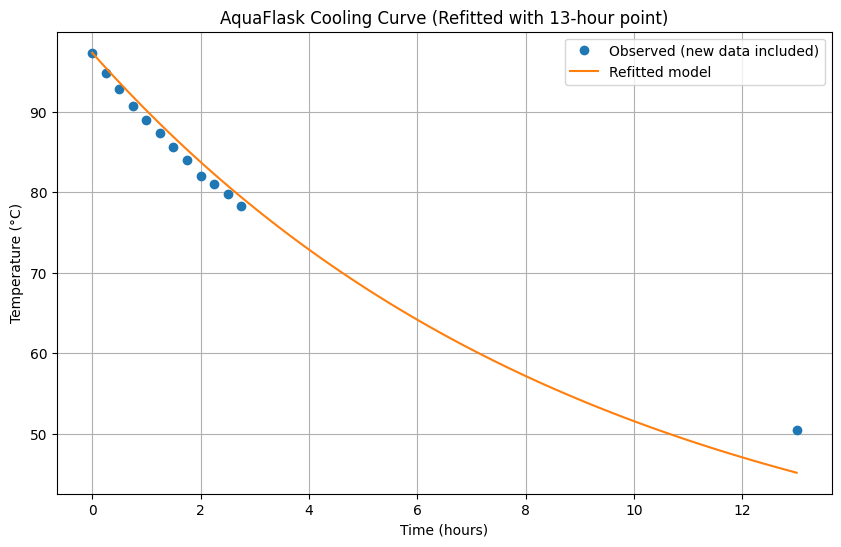

In [65]:
plt.figure(figsize=(10,6))
plt.plot(data['Elapsed_hours'], T_temp, 'o', label='Observed (new data included)')
plt.plot(time_fit, fitted_temps, '-', label='Refitted model')
plt.xlabel('Time (hours)')
plt.ylabel('Temperature (°C)')
plt.title('AquaFlask Cooling Curve (Refitted with 13-hour point)')
plt.legend()
plt.grid(True)
plt.show()
